# Project 2
Dieter Brehm and Corinne Wilklow - Project 2 - Fall 2018  
A project examining the relationship and lag time between inner and outer temperates of a house, and how insulation can be optimized for climate.

In [205]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import matplotlib.image as mpimg

### Question: How much insulation of what type should be installed in a house to maintain a chosen comfortable temperature over the course of eighty hours in a house in London?

### Model:
We made a number of assumptions in order to clarify and simplify our model. The significant assumptions are summarized as follows:  
* All heat loss in the room transfers directly to outside
* Heat transferred to environment does not affect the temperature of the environment
* Outside temperature is uniform around all sides of the house, including the ground. We didn’t take into account sun or shade surrounding the house, or that the ground might be an entirely different temperature than the air. This causes our model to be very simplistic, but it could easily be iterated into a model that incorporates the difference between air and ground temperature. 
* We set dt to be one half hour, so the other assumption is that there is no great fluctuation in temperature over one half hour. Buried in this assumption is also the assumption that the temperature is constant over that half-hour. 
* We also created a house in which the floor, ceiling and wall insulation is all of the same type and thickness.
* While the dimensions of the house are adjustable in the model, it will always be some variation on a simple box, meaning that we are not concerning ourselves with complex house floor plans or geometries 


We started by importing a selection of r-values for commerically available insulation
into a dataframe, which we will later use as input for a sweep of temperature simulations.

In [206]:
R_data = pd.read_csv('r_values.csv', header=0, index_col=0, usecols=range(1,2))

""
R
1.25
3.71
3.85
4.00
4.13
4.29
5.00
5.00
6.50


Next, we imported the exterior temperature data from a study that examines
the characteristics of a wall in London. We are only concerned with the T_ext column of this data as a convenient dataset for temperature over a few days in london.

In [207]:
# Load dataset values
ext_data = pd.read_csv('DataOWall.csv', parse_dates=[0],
                        index_col=0, header=0, skiprows=[1,2])
ext_data.head()

,Q_in,Q_out,T_int,T_ext
2014-10-05 16:30:00,10.994,6.840,16.92,14.68
2014-10-05 16:35:00,10.952,6.012,16.92,14.69
2014-10-05 16:40:00,10.882,7.040,16.93,14.66
2014-10-05 16:45:00,10.798,8.880,16.93,14.59
2014-10-05 16:50:00,10.756,10.491,16.94,14.50


The data was imported with timestamps that are not very useful for us. In order to easily match our equations, we converted these timestamps to hours.


In [208]:
# Convert Index entries to seconds, noticing the spacing between recordings
timestamp_0 = get_first_label(ext_data)
time_deltas = ext_data.index - timestamp_0;

ext_data.index = time_deltas.days * 86400 + time_deltas.seconds

In [209]:
# convert index entries to hours
ext_data.T_ext.head()
T_ext_external = ext_data.T_ext
for i, v in ext_data.T_ext.items():
    scaled = i / 3600
    T_ext_external = T_ext_external.rename(index={i: scaled})
    
T_ext_external.head()

0.000000    14.68
0.083333    14.69
0.166667    14.66
0.250000    14.59
0.333333    14.50
Name: T_ext, dtype: float64

Here, we plotted the temperature versus time of this data for T_ext. The highs and lows as nights and middays occur are clear in the plot.

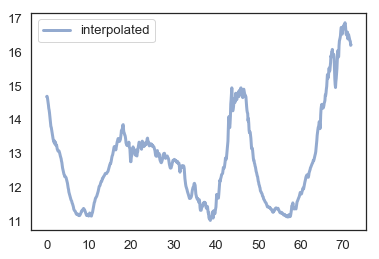

In [210]:
# plot the exterior temp data on top of the interpolation of the data
t_ext_func = interpolate(T_ext_external)
plot(T_ext_external.index, t_ext_func(T_ext_external.index), label="interpolated")
legend()

In our system we made many assumptions about the exact specifications of our house. The dimensions of the house are adjustable, but the model is only built for rectangular prisms. We also created a house in which the floor, ceiling and walls are all made of the same insulation.  
  
We also set dt to be half an hour, assuming that there is no change in temperature over each step. In order to adapt the outside temperature data from OWall to fit this time step, we converted the timestamps to hours and used the interpolate function to estimate intermediate values in the data.  
  
When we chose an assortment of R values, we used the R that corresponds to one inch of material. When you stack insulation together, their R values simply add. By using one inch of every material, we can easily calculate the R-value of increased depths of insulation later in the essay.


In [211]:
def make_system(params):
    """Make a system object for insulation model.
    
    params object should contain:
    T_ext: the starting exterior temperature
    T_int: the starting interior tempature
    R: the R-rating of the insulation, in units ft^2*deg5/btu/hr/in
    d: the depth of the insulation, in units Inches
    l: house length in meters
    w: house width in meters
    h: house height in meters
    c: c value of air for Newton's law of cooling, in units btu/lbm*R
    
    returns: System object
    """
    T_int, T_ext, R, d, l, w, h, c = params
                
    # density of air
    rho = 1

    # m/s^2, acceleration due to gravity
    g = 9.8 
    
    # air volume inside house m^3
    V = l * w * h

    # mass of air in room in lb
    m = (rho * V * g) * 2.2 
                
    # calculate surface area, and convert from m^2 to ft^2
    SA = (l * w * 4 + h * l * 2) * 10.7639

    first = State(T_int=T_int, T_ext=T_ext)
    
    # time constants
    t0 = 0
    t_end = 80
    dt = .5

    return System(init=first, t0=t0, t_end=t_end, dt=dt, R=R, d=d,
                  SA=SA, m=m, c=c)

In [212]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end,system.dt):
        frame.row[t+system.dt] = update_func(frame.row[t], t, system)
    
    return frame

We assumed that all heat flows directly out of the house. This allows our model to precisely quantify all heat loss during a given time frame. We allowed outside temperature to influence inside temperature, but we did not allow heat flow to the outside to influence the outside temperature. This assumption makes sense when analyzing a free-standing structure, but it would not make sense on a densely packed city block.
  
We also assumed that heat flows evenly through all sides of the house, again an assumption that would work for a free-standing house, but not a series of row houses. Embedded in this assumption is the idea that outside temperature is equal at every point around the house. We didn’t take into account sun or shade surrounding the house, or that the ground might be an entirely different temperature than the air. This causes our model to be simplistic, but it could be iterated into a model that incorporates the difference between air and ground temperature.  

In [213]:
def update_func(state, t, system):
    """Update the model.
    
    state: State with variables T_int, T_ext
    dt: time step
    system: System
    
    returns: State object
    """
    
    T_int, T_ext = state
    
    #test this by overwritting state value
    T_ext = t_ext_func(t) * 9 / 5 + 32
    
    delta_T = T_int - T_ext
    
    dQ = (system.SA * delta_T / (system.R * system.d)) * system.dt
   
    if system.c == 0:
        system.c = dQ / delta_T
    
    
    dT = dQ / (system.c * system.m) 
    
    T_int = T_int - dT
    
    #print(dT)
    
    return State(T_int = T_int, T_ext = T_ext)

In order to better visualize our model, we also wrote an update function and run_simulation which does not consider exterior temperature data

In [214]:
def update_func_isolated(state, t, system):
    """Update the model.
    
    state: State with variables T_int, T_ext
    dt: time step
    system: System
    
    returns: State object
    """
    
    T_int, T_ext = state
    
    delta_T = T_int - T_ext
    
    dQ = (system.SA * delta_T / (system.R * system.d)) * system.dt
   
    if system.c == 0:
        system.c = dQ / delta_T
    
    
    dT = dQ / (system.c * system.m) 
    
    T_int = T_int - dT
    
    #print(dT)
    
    return State(T_int = T_int, T_ext = T_ext)

In [215]:
def run_simulation_isolated(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end,system.dt):
        frame.row[t+system.dt] = update_func_isolated(frame.row[t], t, system)
    
    return frame

In [216]:
params = Params(T_int = 60,
                T_ext = get_first_value(ext_data.T_ext)*9/5+32,
                R = 3,
                d = 4,
                l = 6,
                w = 6,
                h = 6,
                c = 0.171)
                
system = make_system(params);

The following plot is of a test run of the simulation which includes only one R-value of 3 to see if the results look reasonable. Knowing that an isolated R-value of 3 with an insulation depth of four inches should follow the exterior curve quite closely, this looks pretty reasonable.

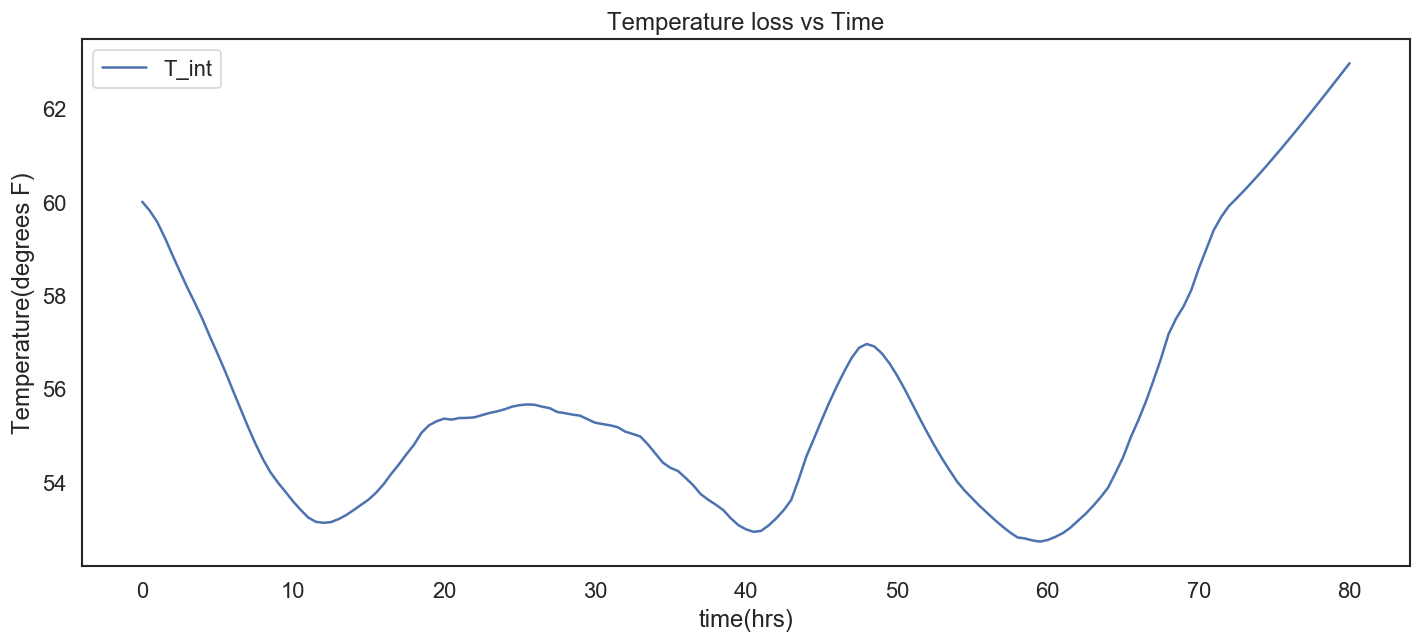

In [217]:
#test the simulation with the r value set in params
results = run_simulation(system, update_func)

fig1 = plt.figure(figsize=(12, 10), dpi=120,)
ax1 = fig1.add_subplot(211)    
ax1.plot(results.T_int)
decorate(title = 'Temperature loss vs Time',
         xlabel = 'time(hrs)',
         ylabel = 'Temperature(degrees F)')

This plot is of a test run of the simulation which is compared to a different paper's data of exterior versus interior temperature of a house in California to see if the results look reasonable. In the paper, they warmed the house up to 70 degrees and then let the interior temperature decay over time, measuring the values. We tuned the system parameters to match those indicated in the paper. Looking at the curves of the two plots, our own and the one from the article, the results look reasonable.

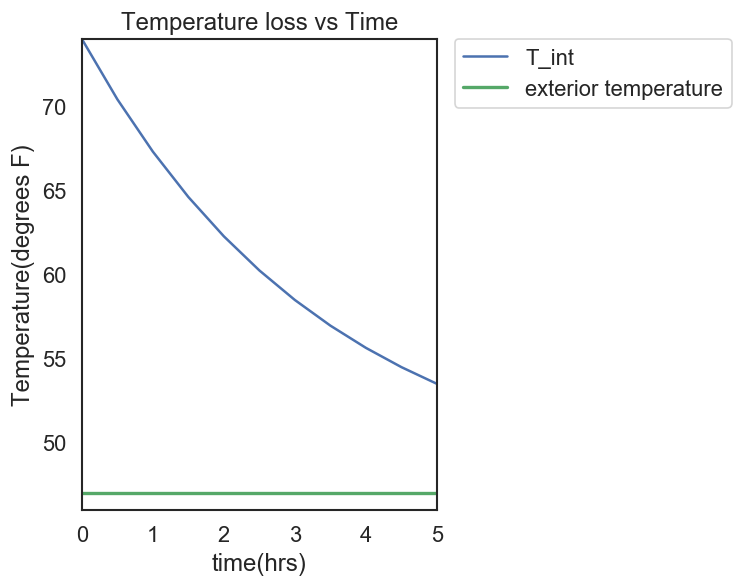

In [218]:
params = Params(T_int = 74,
                T_ext = 47,
                R = 3.1,
                d = 3.5,
                l = 9.8,
                w = 10.6,
                h = 5,
                c = 0.171)
                
system = make_system(params)

#test the simulation with the r value set in params
results = run_simulation_isolated(system, update_func)

fig1 = plt.figure(figsize=(7, 5), dpi=120,)
ax1 = fig1.add_subplot(121)    
ax1.plot(results.T_int)
plt.xlim(0, 300/60)
plt.ylim(46, 74)
ax1.plot([0, 14], [47, 47], color='g', linestyle='-',
         linewidth=2, label="exterior temperature")
decorate(title = 'Temperature loss vs Time',
         xlabel = 'time(hrs)',
         ylabel = 'Temperature(degrees F)') 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


Here is the curve given by the article we found:  
![title](validation.PNG)

### Results:

Then, we composed a function that runs the simulation for all of our commercially-available r-values and overlays the results on the same plot along with the exterior temperature data for comparison.

In [219]:
def sweep_R(R_data):
    """
    Sweep a range of values of R and plot them
    R_data: list of r values
    
    returns: SweepSeries
    """
    
    # names of the commercially available insulations, index of this list matches that or r-val csv
    insulation = ['plywood','EcoTouch','R-tech','Kingspan','Comfortbatt gold',
                  'Comfortbatt blue', 'Foamular','SilveRboard','Super TUFF',
                  'polyisocyanurate (foil-faced)', 'miracle material']
    
    fig1 = plt.figure(figsize=(18, 16), dpi=180)
    ax1 = fig1.add_subplot(211)
    
    for R in R_data.index.values:
        # change our R to the one in this loop of the sweep
        params[2] = R
        systemr = make_system(params)
        results = run_simulation(systemr, update_func)
        location = np.where(R_data.index == R)
        location = location[0].tolist()
        ax1.plot(results.T_int, label=str(R) + ' ' + insulation[location[0]])
 
    ax1.plot(results.T_int.index,
             t_ext_func(results.T_int.index)  * 9 / 5 + 32,
             label="interpolated exterior data")
    
    ax1.plot([0, 80], [55, 55], color='k', linestyle='-', linewidth=2,
             label="minimum acceptable interior temperature")
    
    decorate(title = 'Temperature loss vs Time',
            xlabel = 'time(hrs)',
            ylabel = 'Temperature(degrees F)')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0.)
    plt.show()

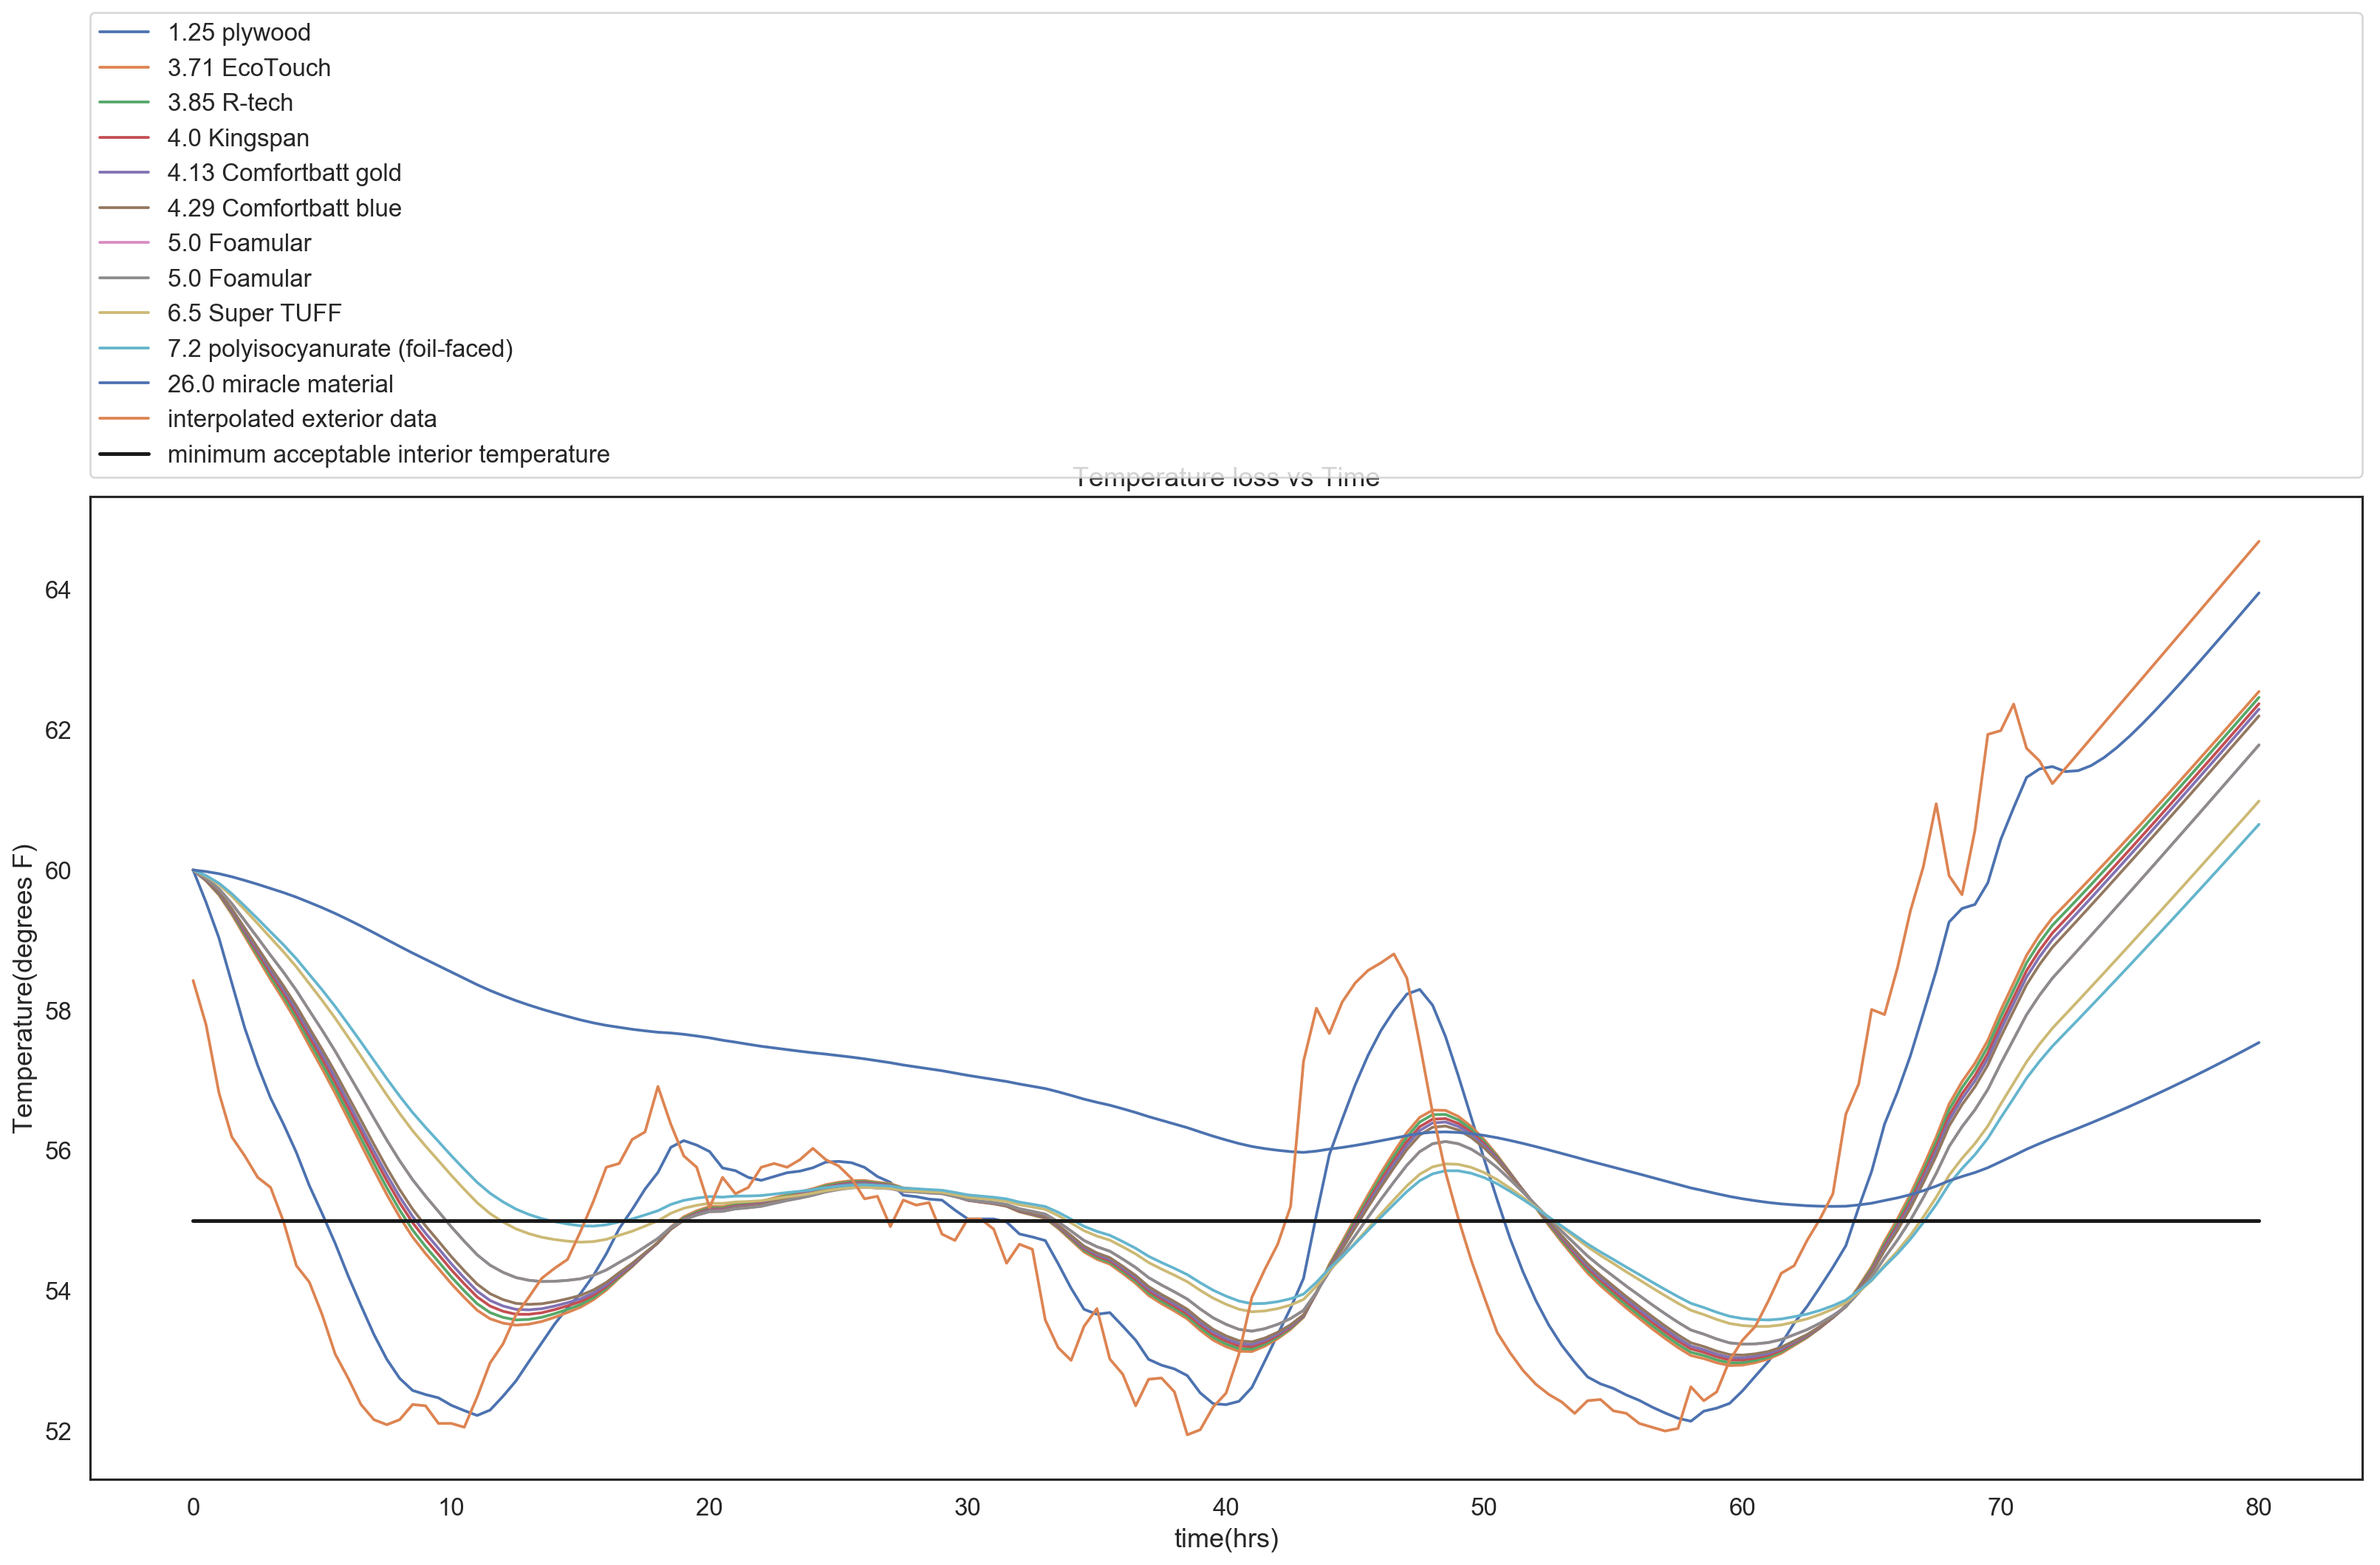

In [220]:
params = Params(T_int = 60,
                T_ext = get_first_value(ext_data.T_ext)*9/5+32,
                R = 3,
                d = 4,
                l = 6,
                w = 6,
                h = 6,
                c = 0.171)
                
system = make_system(params)

sweep_R(R_data)

### Interpretation:

As evidenced by our graph, no one insulation would keep the temperature of the house from falling below the cutoff temperature of 55 degrees Fahrenheit. Realistically though, not many people would have only four inches of insulation in the exterior walls of their house and a heating system that only ran once over the course of 80 hours. In our model we added a “Miracle Material” with an R of 26, to demonstrate how that high of an R value would affect its reaction outside temperature. As it turns out, 26 is the perfect R to keep the house temperature always above the cutoff temperature. 
  
The next step in the project would be to add the rest of walls, like plywood and drywall, to the R values of the insulation, just to truly model a wall. This wouldn’t change the results of the model by very much, but it would do away with some of the assumptions. We could also split the house into different segments, walls are typically constructed differently than roofs and floors.   
  
to figure out exactly how much of each insulation would be required to create an R value of 26. It feels obvious that the higher the R value, the more it stabilizes the temperature. A deeper wall, then, would naturally be more insulating than a thinner wall, but from here we could add in a optimization function to optimize wall depth based on cost of materials. 
